
# Study of antigen loss 

In this notebook we consider the inclusion of antigen loss terms in the master equation (due to dissociation of 2-body complexes under **force-free** off rates).

For simplicity, we neglet rebinding reactions and only consider the following four reactions. 

- BCR-Ag-APC => BCR-Ag + APC, $k_{a, f}$
- BCR-Ag-APC => BCR  +  Ag-APC, $k_{b, f}$
- Ag-APC => Ag + APC, $k_a$
- BCR-Ag => BCR + Ag, $k_b$


In [2]:
import numpy as np
import matplotlib.pyplot as plt
#from importlib import reload
from script.model import bonds as bd
from script.model.model import Force_prm
from script.model import model

In [150]:


prm_dict = {
    "scheme":"step",
    "r":0.1,
    "beta":1.0,
    "mc":100,
    "f0":0,
    "tc":0,
    "elist": [10, 10, 10, 10],
    "r0":1000,
    "s0":1000,
    "l0_list": [100, 0],
    "ton": [1e7, 1e7],
    "tm": int(1e8)
    }


    
    
class Bonds:
    
    def __init__(self, sto, num_pairs=2):
        
        self.sto = sto
        self.num_pairs = num_pairs
        self.apc_list = []
        self.bcr_list = []
        self.bond_list = []  ## [apc1, bcr1, apc2, bcr2, ...]
        self.l0_list = []
        self.elist = np.zeros(num_pairs*2)
        self.ton = 0
        self.r0, self.s0 = 0, 0
        
        self.load_prm(sto.prm_dict)
        self.setup()
        
        
    def setup(self):
        for i in range(self.num_pairs):
            apc, bcr = bd.getBonds(e1=self.elist[i*2], e2=self.elist[i*2+1], ton=self.ton, output=False, pot="phenomenon")
            self.apc_list.append(apc)
            self.bcr_list.append(bcr)
            self.bond_list.append(apc)
            self.bond_list.append(bcr)
            #self.l0_list.append(0) don't know why put this
            del apc, bcr
        
        
    def load_prm(self, prmdict):
        self.r0 = prmdict["r0"]
        self.s0 = prmdict["s0"]
        self.l0_list = prmdict["l0_list"]
        self.elist = prmdict["elist"]
        self.ton = prmdict["ton"]
        pass
    
    def init_bond(self, r0, s0, l0_list):
        """
        initlize the system
        args:
            r0: num of BCR receptor
            s0: num of APC CR receptors
            l0: num of Ag ligands
        """
        self.r0, self.s0=r0, s0
        self.l0_list = l0_list
        return
        
    def get_off_rate(self, f):
        ### return off rates
        ### f in N 
        return [bond.get_off_rate(f) for bond in self.bond_list]
    
    def get_on_rate(self):
        ### return on rates
        return [bond.kon for bond in self.bond_list]
    
    def get_Eb(self):
        return [bond.e1 for bond in self.bond_list]
    
    def get_bond_num(self):
        return self.r0, self.s0, self.l0_list
    
    def set_Eb(self, i, eb):
        self.bond_list[i].e1=eb
        self.bond_list[i].setup()
        
    def set_kon(self, kon):
        for bond in self.bond_list:
            bond.kon = kon
    
    def set_l0(self, l0list):
        self.l0_list= l0list
        return
    
    def set_f(self, f):
        for bond in self.bond_list:
            bond.f0 = f
            bond.setup()
            
    def get_info(self):
        print("Eb: \t\t", self.get_Eb())
        print("off rate:\t", self.get_off_rate(self.sto.f))
        print("life time:\t", 1/np.asarray(self.get_off_rate(self.sto.f)))
        print("on rate:\t", self.get_on_rate())
        print("ligand num:\t", self.r0, self.s0, self.l0_list)
        pass
    
    
    
class Stoch:
    
    def __init__(self, prm_dict, output=False):
        ### number of ag types
        self.num_pairs = 2
        
        ## number of species
        self.num_spec = 2*self.num_pairs
        
        self.prm_dict = prm_dict
        
        self.loadSharing = True
        
        #### maximum bound complex, variable
        self.m_max = 0
        self.m1_max = 0
        
        #### max time steps, parameter
        self.tm = prm_dict["tm"]
        
        self.setup(output)
        pass
    
    
        
    def setup(self, output=False):
        ## get the bonds
        self.bonds = Bonds(self, self.num_pairs)
        ## get the force
        self.force = Force_prm(self)
        self.force.loadprm(self.prm_dict)
        
        ## spec list [m1, n1, m2, n2]
        self.rec_name = []
        self.spec = np.zeros(self.num_spec)
        self.f = self.force.get_f(0) *1e-12 ## pN
        self.m_max = 0
        self.m1_max = 0

        self.bonds.set_f(self.f)

        kf = self.force.get_kf()
        ## reaction rates
        koff = self.bonds.get_off_rate(self.f)
        koff0 = self.bonds.get_off_rate(0)
        kon = self.bonds.get_on_rate()
        
        self.k = []
        # for i in range(self.num_spec):
        #    self.k += [koff[i], kon[i], koff0[i]] ### kaoff, kaon, kboff, kbon, kboff0
        # self.k.append(kf) ## append the force changing rate
        #print("self.k", self.k)
        ## binding energy
        self.e = self.bonds.get_Eb()

        ### setting up the stochastic system
        num_rxn = self.num_pairs*5 + 1
        num_spec = self.num_pairs*2
        self.stoch = np.zeros((num_rxn, num_spec))
        
        for i in range(self.num_pairs):
            #### APC-Agi-BCR ==> APC + Agi-BCR
            self.rec_name.append("APC-Ag"+str(i)+"_off")
            self.stoch[0+i*5, 0+i*2] = -1
            self.stoch[0+i*5, 1+i*2] = 1
            self.k.append(koff[0])

            ### APC + Agi-BCR ==> APC-Agi-BCr
            self.rec_name.append("APC-Ag"+str(i)+"_on")
            self.stoch[1+i*5, 0+i*2] = 1
            self.stoch[1+i*5, 1+i*2] = -1
            self.k.append(kon[0])
            
            ### APC-Agi-BCR ==> APC-Agi + BCR
            self.rec_name.append("BCR-Ag"+str(i)+"_off")
            self.stoch[2+i*5, 0+i*2] = -1
            self.stoch[2+i*5, 1+i*2] = 0
            self.k.append(koff[1])

            ## APC-Agi + BCR ==> APC-Agi-BCR
            self.rec_name.append("BCR-Ag"+str(i)+"_on")
            self.stoch[3+i*5, 0+i*2] = 1
            self.stoch[3+i*5, 1+i*2] = 0
            self.k.append(kon[1])
            
            ## BCR-Agi => BCR + Agi
            self.rec_name.append("BCR-Agi => BCR + Agi")
            self.stoch[4+i*5, 0+i*2] = 0
            self.stoch[4+i*5, 1+i*2] = -1
            self.k.append(koff0[1])

        ## force increasement
        self.rec_name.append("force updates")
        self.stoch[-1, 0] = 0
        self.stoch[-1, 1] = 0
        self.k.append(kf) ## append the force changing rate
        self.k_record = self.k ### used for estimating k when k is unaviailable
        if output:
            print("reaction rates: ", self.k)
        pass
    
    def get_steady_state(self):
        ms1 = int(self.bonds.l0_list[0] * self.k[1] / (self.k[0] + self.k[1]+self.k[2]))
        ns1 = int(self.bonds.l0_list[0] * self.k[0] / (self.k[0] + self.k[1]+self.k[2]))
        return [ms1, ns1, 0, 0]
    
    def set_rate(self, i, k):
        self.k[i] = k
        self.k_record = self.k
        pass
    
    def sample_ea(self, mean, std):
        ### sample a tether affinity based on a normal distribution
        self.prm_dict["elist"][0] = np.random.normal(mean, std)
        self.setup()
        return

    def updateRate(self, t, num_bond=1, output=False):
        ### f is in pN
        if num_bond<1:
            fn = 0
        else:
            fn = self.force.get_f(t, self.m_max)*1.0E-12 ## fn in N
            
        if self.loadSharing and num_bond>0:
                fn = fn/num_bond
                
        koff_list = self.bonds.get_off_rate(fn)
        # for i, koff in enumerate(koff_list):
        #    self.k[i*2] = koff ### update off rate only
        self.k[0] = koff_list[0]
        self.k[2] = koff_list[1]
        self.k[5] = koff_list[2]
        self.k[7] = koff_list[3]
        
        
        
        if output:
            print("apc-koff = ", [koff_list[2*i+0] for i in range(self.num_pairs)])
            print("bcr-koff = ", [koff_list[2*i+1] for i in range(self.num_pairs)])
        
        isNan = False
        for i, off_rate in enumerate(self.k):
            if np.isnan(off_rate) or np.isinf(off_rate):
                if output:
                    print("the off_rate is none", "index=", i, "off_rate=", off_rate)
                isNan =True
        if isNan:
            self.k = self.k_record.copy()
        else:
            self.k_record = self.k.copy()
        return
 
    def get_info(self):
        self._print2("="*12)
        self._print2("num pairs: {0:d}, num_spec={1:d}".format(self.num_pairs, self.num_spec))
        self._print2("bond info:")
        self.bonds.get_info()
        
        self._print2("-"*12)
        self._print2("force info:")
        self.force.get_info()
        
        self._print2("-"*12)
        self._print2("complex info:")
        self._print2("bond states: m1={0:d}, n1={1:d}, m2={2:d}, n2={3:d}".format(int(self.spec[0]), int(self.spec[1]),int(self.spec[2]), int(self.spec[3])))
        self._print2("m max: {0:.1f}".format(self.m_max))
        
        self._print2("-"*12)
        self._print2("reaction rate:")
        self._print2("{}".format(self.k))
        
        
        return
    
    def _print2(self, s):
        print(s)
        return
        
#     def manyRun(self, cycle,  n=1000, output=True):
#         tEnd = []
#         nbarList = []
#         for i in range(cycle):
#             #self.reset()
#             self.run(n, output=output)
#             tEnd.append(np.mean(self.tlist))
#             nbarList.append(self.nbar)
            
#         nbar_mean = np.mean(nbarList)
#         nbar_std = np.std(nbarList)
#         tEnd_mean = np.mean(tEnd)
#         self.tlist= tEnd
#         if output:
#             for nbar in nbarList:
#                 print("{:.4f}".format(nbar), end="\t")
#             print("{:.2e}".format(np.mean(tEnd)))

#             print("mean nbar: {0:.4f}, std nbar: {1:.4f}".format(nbar_mean, nbar_std))
#             print("{0:.4f}\t{1:.4f}\t{2:.2f}".format(nbar_mean, nbar_std, tEnd_mean))
#         return nbar_mean, nbar_std, tEnd_mean

    def extract_from_another_bcell(self, another_sto):
        nag0 = self.nags[0] + another_sto.nags[0]
        koff1 = self.bonds.get_off_rate(0)
        koff2 = another_sto.bonds.get_off_rate(0)
        self.nags[0] = sample_nag(nag0, koff2[1], koff1[1])
        another_sto.nags[0] = nag0 - self.nags[0]
        return

    def run(self, n=1000,  output=True):
        init = [self.prm_dict["l0_list"][0], 0, self.prm_dict["l0_list"][1], 0]
        tList = []
        #n0List = [] ## apc-ag-bcr list
        n1List = [] ## ag-bcr list
        n2List = []
        m1List, m2List = [], []
        fList = []
        self.p = 0
        self.tend = 0
        self.nag_list = []
        self.flist = []
        self.free_ag_list = []
        
        frList0, frList1 = [], [] ## mean rupture force list for both bonds
        mMaxList = [] ## m max
        
        for i in range(n):
            self.setup()
            #tList_tmp, Alist_tmp,  flag, f_rup = reaction(self, init, storeData=False)
            tList_tmp, Alist_tmp,  flag = reaction(self, init, storeData=False)
            #if self.m_max < 2:
            #    continue
            if flag:
                tList.append(tList_tmp)
                m1List.append(Alist_tmp[0])
                n1List.append(Alist_tmp[1])
                m2List.append(Alist_tmp[2])
                n2List.append(Alist_tmp[3])
                self.free_ag_list.append(Alist_tmp[4])
                
                fList.append(self.force.f)
                mMaxList.append(self.m1_max)
                #frList0.append(f_rup[0])
                #frList1.append(f_rup[1])
                
            else:
                #raise Exception("simulation not finished!")
                return None, None, None
            if output:
                model.printProgress(i, n)
                
        nList = [n1List[i] + n2List[i] for i in range(len(n1List))]
                
        self.nbar = np.mean(np.asarray(nList))
        self.nstd = np.std(np.asarray(nList))
        self.nags_list = [n1List, n2List]
        self.ms_list = [m1List, m2List]
        self.mmax_list = mMaxList
        self.flist = fList
        
        t_mean = np.mean(tList)
        f_mean = np.mean(fList)
        self.m_max_mean = np.mean(mMaxList)
        #self.fr_mean = [frList0, frList1]
        self.tlist = tList
        #print(n1List)
        
        if output:
            print("count=", n)
            print("nbar={0:.5f}, nstd={1:.5f}, t={2:.2f}, f={3:.3f}, free_ag={4:.2f}".format(self.nbar, self.nstd, t_mean, f_mean,
                    np.mean(self.free_ag_list)
                                                                                            ))
            #print("{0:.5f}\t{2:.2f}".format(eta_mean, eta_std, t_mean))
        return self.nbar, self.nstd, t_mean
    
    def run1(self, output=True, storeData=True, init=None, sample_rate=1):
        
        
        if init is None:
            init = [self.prm_dict["l0_list"][0], 0, self.prm_dict["l0_list"][1], 0] ## set initial condition [l0list[0], 0, l0list[1], 0]
        elif init=="steady_state":
            init = self.get_steady_state()
        if storeData:
            self.t_record=[]
            self.spec_record = []
            self.f_record = []
            self.a = []

            self.f_rup = [] ### record force per bond at rupture 
            t, spec, force, a, self.f_rup = reaction(self, init, storeData=True, output=output, sample_rate=sample_rate)
            if output:
                print(t.shape, spec.shape)
                print(spec[-1, 0])
            self.t_record = t[:, 0]
            self.spec_record = spec
            
            self.free_nag_record = self.get_free_ag(spec)
            self.f_record = force
            self.a = a
            return t, spec
        else:
            tList_tmp, Alist_tmp,  flag  = reaction(self, init, storeData=False, output=output)
            self.spec_record = Alist_tmp
            self.tend = tList_tmp
            if flag:
                self.nags = [Alist_tmp[1], Alist_tmp[3]]
                self.tend = tList_tmp
                self.free_ag = Alist_tmp[4]
            else:
                if output:
                    print("simulation not finished. Please incrase t_end")
                self.nags = [np.nan, np.nan]
                self.tend = np.nan
            return self.nags, self.tend
        
    def get_free_ag(self, spec_rec):
        m_history = spec_rec[:, 0]
        n_history = spec_rec[:, 1]
        l_history = [0]
        for i in range(1, len(n_history)):
            if n_history[i] < n_history[i-1]:
                l_history.append( l_history[-1] + 1)

            else:
                l_history.append( l_history[-1])
        return l_history
    

    def get_critical_F(self, output=False):
        m_critical = 0
        f_critical = 0
        length = len(self.f_record)
        if length<=2:
            m_critical = 1
            f_critical = self.f_record[0]
            f_max = self.f_record[0]
        for i in range(length-1, 0, -1):
            if self.spec_record[i, 0] < self.spec_record[i-1, 0]:
                continue
            else:
                m_critical = self.spec_record[i, 0]
                f_critical = self.f_record[i]
                self.t_c = i
                break

        if output:
            print("mc= {0:.2f},  fc= {1:.3f}, fc/mc={2:.3f}".format(m_critical, f_critical, f_critical/m_critical))
            print("mmax={0:.2f}, fmax={1:.3f}, fmax/mmax={2:.3f}".format(self.m_max, max(self.f_record),max(self.f_record)/self.m_max ))
        return m_critical, f_critical, self.m_max, max(self.f_record)
    
    
def reaction(sto, init, output=False, storeData=False, debug=False, sample_rate=1):
    """
    sto: stochastic reaction class, contains:
        stoch: numpy array, stochastic reaction matrix
        updateRate: function, update the rate
        
    init: initial codition [num of BAC, num of BA]
    """
    largeNum = int(1e5)
    Force_Inc_Index = 10
    Bond1_Rup_Index = [0, 2]
    Bond2_Rup_Index = [5, 7]
    if output:
        print("Info:")
        print("  Init population: [APC-Ag-BCR, Ag-BCR] = ", init)
        print("  reaction rate: \n  Bond\tAPC\tBCR")

    num_rxn = np.shape(sto.stoch)[0]
    num_spec = np.shape(sto.stoch)[1]
    current_t = 0
    current_species = init.copy()
    
    f_rup1, f_rup2 = [], [] ## store the force per bond at rupture
    
    
    if storeData:
        store_t = np.zeros((largeNum, 1))
        store_spec = np.zeros((largeNum, num_spec))
        
        store_a = np.zeros((largeNum, 4))
        
        store_t[0] = 0
        store_spec[0] = np.asarray(current_species)
    
    free_ag  = 0
    store_rec = np.zeros(num_rxn, dtype=int)
    store_f = np.zeros(largeNum, dtype=float)
    store_f[0] = sto.force.f
    t_count = 0
    t_record = 0
    
    step = 0
    #while (current_species[0]>0 and t_count<largeNum):
    finished = True
    
    a = np.ones(num_rxn)
    sto.m_max = current_species[0]
    sto.updateRate(current_t, current_species[0])
    
    r0, s0, l0list = sto.bonds.get_bond_num()
    outputflag = False ### mark output state
    while (current_species[0]+current_species[2]>0 or step==0 or current_t<sto.force.tc):
        ### ending condition: no forms and duration is larger than 1000
        #### APC-Ag1-BCR ==> APC + Ag-BCR
        #### a = k1off * m1
        a[0] = sto.k[0]*current_species[0]
        
        ### APC + Ag1-BCR ==> APC-Ag-BCR
        ## a = k1on*n1*(s0 - l10 - l20 + n1 + n2)
        a[1] = sto.k[1]*current_species[1]#*(s0-sum(l0list)+current_species[1]+current_species[3])
        
        ### APC-Ag1-BCR ==> APC-Ag + BCR
        #### a = k2off * m1
        a[2] = sto.k[2]*current_species[0]
        
        ## APC-Ag1 + BCR ==> APC-Ag-BCR
        ## a = k2on*(r0-m1-n1-m2-n2)*(l10-m1-n1)
        a[3] = sto.k[3]*(l0list[0]-current_species[0]-current_species[1])#*(r0-sum(current_species))
        
        
        a[4] = sto.k[4]*current_species[1]
        
        
        ## APC-Ag2-BCR ==> APC + Ag2-BCR
        ### a = k1off * m2
        a[5] = sto.k[5]*current_species[2]
        

        ### APC + Ag2-BCR ==> APC-Ag2-BCR
        ## a = k2on*n2*(s0-l10-l20+n1+n2)
        a[6] = sto.k[6]*current_species[3]*(s0-sum(l0list)+current_species[1]+current_species[3])
        
        ## APC-Ag2-BCR ==> APC-Ag2 + BCR
        ### a = k2off * m2
        a[7] = sto.k[7]*current_species[2]
        
        ### APC-Ag2 + BCR ==> APC-Ag2-BCR
        ## a = k2on*(r0-m1-n1-m2-n2)*(l20-m1-n1)
        a[8] = sto.k[8]*(r0-sum(current_species))*(l0list[1]-current_species[2]-current_species[3])
        
        a[9] = sto.k[9]*current_species[3]
        
        ## force increasement
        a[Force_Inc_Index] = sto.k[Force_Inc_Index]
        
        #print(a)
        for ai in a:
            if ai <0:
                print("Error: a<0")
                print("current species: ", current_species)
                raise Exception("a<0: ", a)
        
        t, next_r = model.choose_t_r(sum(a), a)
        #print(t, next_r)
        #### specific for time dep. step F
        if sto.force.scheme=="step":
            
            if current_t<sto.force.tc and current_t+t>sto.force.tc:
                #print("step=", step)
                next_r = Force_Inc_Index
                t = sto.force.tc-current_t+0.01
        store_rec[next_r] += 1
        if not (np.isnan(t)):
            current_t += t
        assert not np.isnan(current_t), print("current_t type", type(current_t)) 
        #print(current_t)
        ### record the force per bond at rupture
        if next_r in Bond1_Rup_Index:
            f_rup1.append(sto.force.f/(current_species[0]+current_species[2]))
        elif next_r in Bond2_Rup_Index:
            f_rup2.append(sto.force.f/(current_species[0]+current_species[2]))

        if next_r != Force_Inc_Index:
            ## if a reaction happened
            current_species += sto.stoch[next_r, :]
            t_record += 1
            step += 1

            if sto.m_max < current_species[0]+current_species[2]:
                sto.m_max = current_species[0]+current_species[2]
            if sto.m1_max < current_species[0]:
                sto.m1_max = current_species[0]
            for spec in current_species:
                if spec<0:
                    print("ERROR: spec<0")
                    print("current species ", current_species)
                    print("current time: ", current_t)
                    if np.isnan(current_t):
                        print("current time: ", store_t[t_count-2])
                    raise Exception("spec<0, ", spec)
        if next_r == 4:
            free_ag += 1
                
        sto.updateRate(current_t, current_species[0]+current_species[2])
        #sto.updateRate(step, current_species[0]+current_species[2])
        #print("step=", step, "k=", sto.k)
        if step< 5*sample_rate or t_record >= sample_rate:
            sto.spec = current_species
            t_count += 1
            if output:
                print("step=", step, "||",  end='\r')
            if storeData:
                store_t[t_count] = current_t
                store_spec[t_count] = np.asarray(current_species)
                store_f[t_count] = sto.force.f
                store_a[t_count] = np.asarray([a[0]+a[1], a[2]+a[3], a[4]+a[5], a[6]+a[7]])
            if t_count >= largeNum-1:
                
                if output and not outputflag:
                    print("------- Warning: Some complex remains bound!!!-----")
                    print("Final pop (Sim):\n\tBCR-Ag:\t\t", current_species[1])
                    print("\tAg-CR:\t\t", init[0]-sum(current_species))
                    print("\tCR-Ag-BCR:\t\t", current_species[0])
                    outputflag = True
                    
                if storeData:
                    store_spec[t_count-1] = [None, None, None, None]
                    store_spec[t_count] = [None, None, None, None]
                    store_t[t_count-1] = None
                    store_t[t_count] = None
                    #current_t = None
                    #current_species = [None, None, None, None]
                    finished = False
                    break
            
            t_record = 0
            
            
        if current_t > sto.tm: 
            #current_t = None
            #current_species = [None, None, None, None]
            finished = False
            break
    #print("step=", step)    
    #if finished and t_count < largeNum-1 and output:
    if finished and output:
        print("Finished at step", step)
        print("Final pop (Sim):\n\tBCR-Ag:\t\t", current_species[1], "\n\tAg-CR:\t\t",  init[0]-sum(current_species))
        print("Final time: {:.3e}".format(current_t))
        print("reaction counts:")
        for i in range(num_rxn):
            print("\t{0:s}:\t{1:d}".format(sto.rec_name[i], store_rec[i]))
    elif output:
        if not finished:
            print("unfinished!")
        print("current time: ", current_t)
        print("current step: ", step)
    if storeData:
        return store_t[:t_count+1], store_spec[:t_count+1], store_f[:t_count+1], store_a[:t_count+1], [f_rup1, f_rup2]
    else:
        current_species = np.concatenate([current_species, [free_ag]])
        return current_t, current_species,  finished #, [np.mean(f_rup1), np.mean(f_rup2)]

In [155]:
prm0 = prm_dict.copy()
prm0["scheme"] = "step"
prm0["tc"] = -1
prm0["l0_list"] = [100, 0]
prm0["f0"] = 0 
prm0["elist"] = [10, 14, 10, 10]
prm0["ton"] = 1e20
#prm0['tm'] = 2


In [156]:
sto = Stoch(prm_dict=prm0, output=True)
sto.loadSharing = False

reaction rates:  [4.539992976248485e-05, 1e-20, 8.315287191035679e-07, 1e-20, 8.315287191035679e-07, 4.539992976248485e-05, 1e-20, 8.315287191035679e-07, 1e-20, 8.315287191035679e-07, 0]


In [157]:
res = sto.run1(output=True)

Info:
  Init population: [APC-Ag-BCR, Ag-BCR] =  [100, 0, 0, 0]
  reaction rate: 
  Bond	APC	BCR
Finished at step 102
Final pop (Sim):
	BCR-Ag:		 96.0 
	Ag-CR:		 4.0
Final time: 8.806e+04
reaction counts:
	APC-Ag0_off:	98
	APC-Ag0_on:	0
	BCR-Ag0_off:	2
	BCR-Ag0_on:	0
	BCR-Agi => BCR + Agi:	2
	APC-Ag1_off:	0
	APC-Ag1_on:	0
	BCR-Ag1_off:	0
	BCR-Ag1_on:	0
	BCR-Agi => BCR + Agi:	0
	force updates:	0
(103, 1) (103, 4)
0.0


Text(0, 0.5, 'Number of bonds')

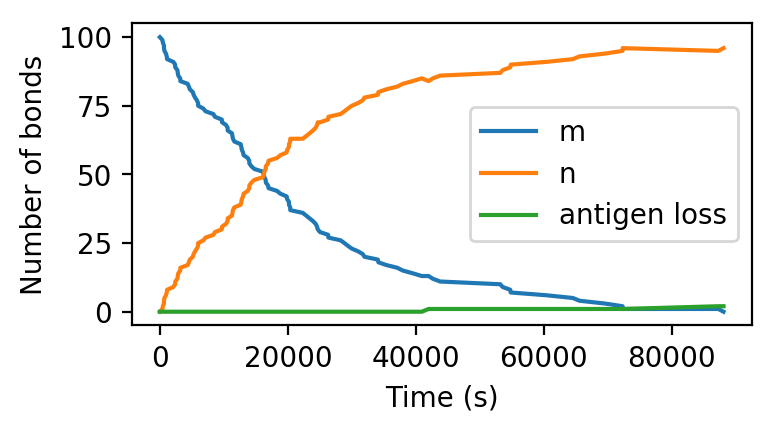

In [158]:
fig, ax = plt.subplots(figsize = (4, 2), dpi=200)
l_record = get_free_ag(sto.spec_record)
plt.plot(sto.t_record, sto.spec_record[:, :2])
plt.plot(sto.t_record, l_record)

plt.legend(["m", "n", "antigen loss"])
plt.xlabel("Time (s)")
plt.ylabel("Number of bonds")
#plt.xlim(0, 500)

In [141]:
sto.run(n=10)

count= 10
nbar=20.60000, nstd=3.74700, t=638.42, f=10.000, free_ag=0.30


(20.6, 3.746998799039039, 638.4188218157577)

In [142]:
sto.free_ag_list

[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0]

In [160]:
flist = np.linspace(0, 20, 6)
eblist = np.linspace(5, 15, 11)

free_ag_list = []
nag_list = []
for fi in flist:
    tmp = []
    tmp2 = []
    for eb in eblist:
        print(f"{fi}, {eb}...")
        prm0["f0"] = fi
        prm0["elist"] = [10, eb, 10, 10]
        sto = Stoch(prm_dict=prm0, output=False)
        sto.loadSharing = False
        sto.run(1000)
        tmp.append(np.mean(sto.free_ag_list))
        tmp2.append(sto.nbar)
    free_ag_list.append(tmp.copy())
    nag_list.append(tmp2.copy())
        

0.0, 5.0...
count= 1000................................................99%
nbar=0.03700, nstd=0.18876, t=767.56, f=0.000, free_ag=0.64
0.0, 6.0...
count= 1000................................................99%
nbar=0.08800, nstd=0.30374, t=2089.24, f=0.000, free_ag=1.67
0.0, 7.0...
count= 1000................................................99%
nbar=0.28300, nstd=0.54855, t=5346.41, f=0.000, free_ag=4.35
0.0, 8.0...
count= 1000................................................99%
nbar=0.80800, nstd=1.05410, t=13468.64, f=0.000, free_ag=11.12
0.0, 9.0...
count= 1000................................................99%
nbar=2.47200, nstd=2.03057, t=30778.60, f=0.000, free_ag=24.60
0.0, 10.0...
count= 1000................................................99%
nbar=8.20000, nstd=4.65940, t=57200.63, f=0.000, free_ag=41.64
0.0, 11.0...
count= 1000................................................99%
nbar=25.84600, nstd=8.47539, t=83141.26, f=0.000, free_ag=47.00
0.0, 12.0...
count= 1000..............

count= 1000
nbar=8.38300, nstd=2.77854, t=6.70, f=20.000, free_ag=0.00
20.0, 11.0...


progress: ................................................96%

count= 1000
nbar=19.41100, nstd=3.94158, t=15.91, f=20.000, free_ag=0.01
20.0, 12.0...


progress: ................................................96%

count= 1000
nbar=39.78200, nstd=4.95242, t=32.62, f=20.000, free_ag=0.01
20.0, 13.0...


count= 1000................................................99%
nbar=64.17600, nstd=4.68605, t=52.09, f=20.000, free_ag=0.01
20.0, 14.0...
count= 1000................................................99%
nbar=82.82800, nstd=3.92281, t=68.19, f=20.000, free_ag=0.00
20.0, 15.0...
count= 1000................................................99%
nbar=92.93500, nstd=2.64854, t=75.99, f=20.000, free_ag=0.00
